In [2]:
# Description
"""

Last modified 11.02.2016
    Added mongoDB support
    pandas avr_table dumps to csv file in 'folder' directory 

08.02.2016
Pandas functionality added, now can be saved to database

New - sifting works correctly, 
        in dataD images which are sifted indicated as isgood=False, 
        fits now use parame
        ter sigma = 'yerr' to calculate fit,
        

""";

In [35]:
# Imports and initialization
%pylab inline

import sys
import os
par_dir = os.path.split(os.getcwd())[0]
if par_dir not in sys.path:
    sys.path.append(par_dir)
import inspect
import pickle
import imp
import re
import json
from scipy.optimize import curve_fit
import pandas as pd
from scipy.integrate import quad
from sympy import Symbol, integrate
import copy

# from IPython.html import widgets
# from IPython.display import display
# from IPython.html.widgets import interact, interactive, fixed


import thulium_python_lib.usefull_functions as usfuncs
import thulium_python_lib.image_processing_new as impr

import ipyparallel as ipp
ipp.CompositeError.tb_limit = 1

rc1 = ipp.Client()
lview = rc1.load_balanced_view()
dview = rc1.direct_view()
dview['par_dir'] = par_dir
# with dview.sync_imports():
#     import sys, os    
%px import sys, os
%px if par_dir not in sys.path: sys.path.append(par_dir)
%px import thulium_python_lib.image_processing_new as impr
%px import imp
%px from ipyparallel import bind_kernel; bind_kernel()

import datetime
import pymongo
from pymongo import MongoClient
from bson.objectid import ObjectId

# start mongoDB client (mongod server should be launched)
# client = MongoClient('mongodb://localhost:27017/')
client = MongoClient('mongodb://192.168.1.15:27017/')
meas_database = client.measData.meas_data

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [36]:
# to reload library on remote and local engine
%px imp.reload(impr)
imp.reload(impr)
# imp.reload(usfuncs)

[stdout:0] Done importing, module image_processing now
[stdout:1] Done importing, module image_processing now
[stdout:2] Done importing, module image_processing now
[stdout:3] Done importing, module image_processing now


Out[0:21]: <module 'thulium_python_lib.image_processing_new' from 'Z:\\thulium_python_lib\\image_processing_new.py'>

Out[1:21]: <module 'thulium_python_lib.image_processing_new' from 'Z:\\thulium_python_lib\\image_processing_new.py'>

Out[2:21]: <module 'thulium_python_lib.image_processing_new' from 'Z:\\thulium_python_lib\\image_processing_new.py'>

Out[3:21]: <module 'thulium_python_lib.image_processing_new' from 'Z:\\thulium_python_lib\\image_processing_new.py'>

Done importing, module image_processing now


<module 'thulium_python_lib.image_processing_new' from 'Z:\\thulium_python_lib\\image_processing_new.py'>

### And now:


#### Choose working directory and measurement folder

In [121]:
# smth like 'D:\!Data\2015_08_20' for lab and like '/Users/artemgolovizin/Downloads/2015_08_20' for mac
os.chdir(r'\\BIGONE\!Data\2016_05_27 T green\Vertical position/')
# os.chdir(r'/Users/artemgolovizin/Downloads/2015_08_20/')
# print('Current directory', os.getcwd());
current_directory = os.path.split(os.getcwd())[-1]
# Create folder 'Figures' for saving individual plot
if not os.path.exists('Figures'):
    os.makedirs('Figures')
    print('Folder Figures has been created')
working_directory = ''
folder = ''

In [125]:
# specify working folder
folder = '02 VP f=364.6/'
working_directory = os.path.join(os.getcwd(),folder)
# print('Working directory', working_directory)

dirs = [x for x in os.listdir() if re.match('\d',x)]
meas_type, conf_params, x_lbl, y_lbl, xaxis_calib = impr.get_x_calibration(folder, dirs)

### Load data, rearange, average and calibrate
 Constract loader and averager. For available parameters see help('instance')

In [126]:
# create loader
loader  = impr.Load_Image(dview)
# downloading images
all_data = loader(working_directory,lview)

# rearranging to dictionary
dataD = impr.rearrange_data(all_data)

 170/170 tasks finished after    2 s
done

Total number of images:  170
Rearranging to dictionary is complited


In [127]:
for key in dataD:
    imgs = dataD[key][1]
    #print(key)
    #print([x.image.shape for x in imgs])

In [128]:
# create averager
averager = impr.Avr_Image(dview,do_sifting=True,conf_int=0.1)
# averaging data and fitting
avr_dataD = averager(dataD,lview)

# construct new data dictionary without image and calibration atoms number, size and x-axis
#navrD = impr.mod_avrData(avr_dataD, xaxis_calib, impr.N_atoms(width=0.5, delta = 5), impr.real_size)
#gain_tmp=200 # 2016_05_04, 2016_05_11, 2016_05_12
gain_tmp=300 # 2016_05_05
#gain_tmp=400 # 2016_05_06, 2016_05_07, 2016_05_08
navrD = impr.mod_avrData(avr_dataD, xaxis_calib, impr.N_atoms(gain=gain_tmp, exposure=200, power=6.3, width=1.85, delta = 5), impr.real_size)

avr_table = impr.get_pandas_table2(navrD)
# for plotting sifted image

#imshow(imread('1 от частоты амплитудной модуляции аома верди (5) 3.9W/26ms/2_1.png'))
#colorbar()

  17/17 tasks finished after    0 s
done
0 images are sifted in folder=0.000000,shot_typeN=1
0 images are sifted in folder=1.000000,shot_typeN=1
0 images are sifted in folder=2.000000,shot_typeN=1
0 images are sifted in folder=3.000000,shot_typeN=1
0 images are sifted in folder=4.000000,shot_typeN=1
0 images are sifted in folder=5.000000,shot_typeN=1
0 images are sifted in folder=6.000000,shot_typeN=1
0 images are sifted in folder=7.000000,shot_typeN=1
0 images are sifted in folder=8.000000,shot_typeN=1
0 images are sifted in folder=9.000000,shot_typeN=1
0 images are sifted in folder=10.000000,shot_typeN=1
0 images are sifted in folder=-2.000000,shot_typeN=1
0 images are sifted in folder=-6.000000,shot_typeN=1
0 images are sifted in folder=-5.000000,shot_typeN=1
0 images are sifted in folder=-4.000000,shot_typeN=1
0 images are sifted in folder=-3.000000,shot_typeN=1
0 images are sifted in folder=-1.000000,shot_typeN=1



In [129]:
# convention table for filenames
#impr.meas_types

In [130]:
#help(Figure)

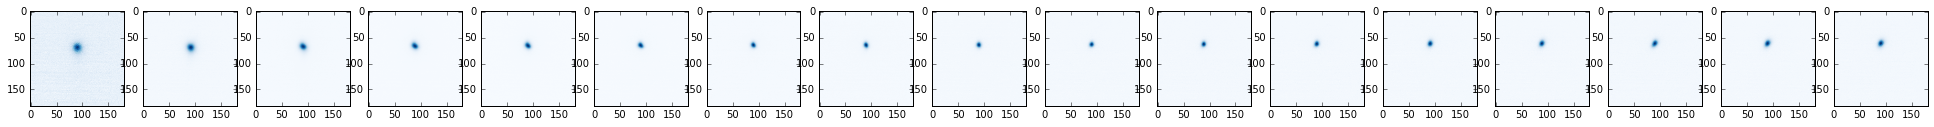

In [131]:
#imshow(avr_dataD[9][1.0].image,cmap=get_cmap('Greens'),vmin=0,vmax=0.01)
fig,ax = subplots(1,len(avr_dataD),figsize=(len(avr_dataD)*2,10))
for i,key in enumerate(sorted(avr_dataD)):
    #print(key)
    ax[i].imshow(avr_dataD[key][1.0].image[:,:],cmap=get_cmap('Blues'))
#imshow(avr_dataD[364.49][1.0].image[:150,:200],cmap=get_cmap('Greens'),vmin=0,vmax=0.056)
#colorbar()
#print('Center vertical position', avr_table.T[0].center_pos.x, 'um')
#print('Center horizontal position', avr_table.T[0].center_pos.y, 'um')
#avr_table.T

In [132]:
#imshow(avr_dataD[9][1.0].image,cmap=get_cmap('Greens'),vmin=0,vmax=0.01)
#fig,ax = subplots(1,len(avr_dataD),figsize=(50,2.5),sharey=True,sharex=True)
#tbls = []
#for i,key in enumerate(sorted(avr_dataD)):
#    print(key)
#    ax[i].imshow(avr_dataD[key][1.0].image,cmap=get_cmap('Blues'))
#    ax[i].axis('off')
#    tbls.append(avr_dataD[key][1.0].image)
#imshow(avr_dataD[364.49][1.0].image[:150,:200],cmap=get_cmap('Greens'),vmin=0,vmax=0.056)
#colorbar()
#print('Center vertical position', avr_table.T[0].center_pos.x, 'um')
#print('Center horizontal position', avr_table.T[0].center_pos.y, 'um')
#avr_table.T

#tight_layout()

In [133]:
pd

<module 'pandas' from 'C:\\Program Files\\Anaconda\\lib\\site-packages\\pandas\\__init__.py'>

In [134]:
#b = pd.concat([pd.DataFrame(avr_dataD[x][1].image) for x in sorted(avr_dataD)],axis=1)
#b = pd.concat([pd.DataFrame(avr_dataD[x][1].image[0:200,0:200]) for x in [364.0,364.1,364.2,364.3,364.4,364.5]],axis=1)
#figsize(20,10)
#imshow(b,cmap=get_cmap('Blues'))

In [135]:
from scipy.ndimage import gaussian_filter

# Вид ловушки от мощности при трех отстройках

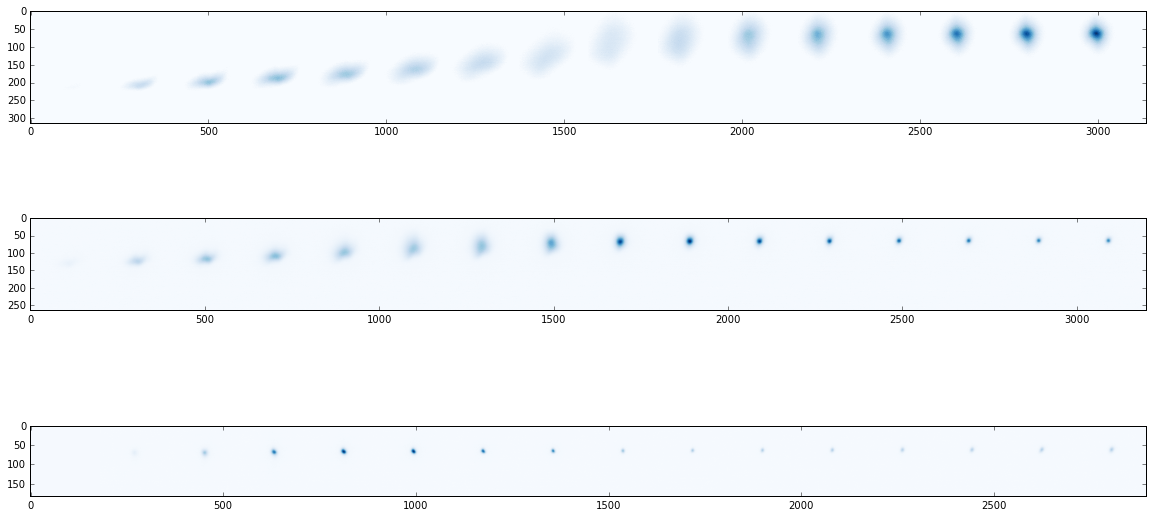

In [143]:
# _365_5, _364_2, 364_6

#bb_364_6 = dict()
#bb_364_6 = copy.deepcopy({x:avr_dataD[x][1].image for x in sorted(avr_dataD)})

##for x in sorted(avr_dataD):
##    bb[x] = avr_dataD[x][1].image

setp = bb_363_5.keys()
#setp = [363.0,363.1,363.2,363.3,363.4,363.5,363.6,363.7,363.8,363.9,364.0,364.1,364.2,364.3,364.4,364.5]
#setp = [-6.0,-5.0,-4.0,-3.0,-2.0,-1.0,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,10.0]
setp = [-7.0,-6.0,-5.0,-4.0,-3.0,-2.0,-1.0,0.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,10.0]

figsize(20,10)

subplot(3,1,1)
b = pd.concat([pd.DataFrame(bb_363_5[x][0:320,0:200]) for x in sorted(setp)],axis=1)
#b = pd.concat([pd.DataFrame(bb_363_5[x][0:320,0:200]) for x in sorted(bb_363_5)],axis=1)
aaa = pd.DataFrame(gaussian_filter(log(b),0.5))
imshow(aaa.fillna(-9),cmap=get_cmap('Blues'))#vmin=0.01,
imshow(b,cmap=get_cmap('Blues'))#,vmin=0.005

subplot(3,1,2)
b = pd.concat([pd.DataFrame(bb_364_2[x][0:320,0:200]) for x in sorted(setp)],axis=1)
#b = pd.concat([pd.DataFrame(bb_364_2[x][0:320,0:200]) for x in sorted(bb_364_2)],axis=1)
aaa = pd.DataFrame(gaussian_filter(log(b),0.5))
imshow(aaa.fillna(-9),cmap=get_cmap('Blues'))#vmin=0.01,
imshow(b,cmap=get_cmap('Blues'))

subplot(3,1,3)
bb_364_6[-7] = zeros(bb_364_6[-6].shape)
b = pd.concat([pd.DataFrame(bb_364_6[x][0:320,0:200]) for x in sorted(setp)],axis=1)
#b = pd.concat([pd.DataFrame(bb_364_6[x][0:320,0:200]) for x in sorted(bb_364_6)],axis=1)
aaa = pd.DataFrame(gaussian_filter(log(b),0.5))
imshow(aaa.fillna(-9),cmap=get_cmap('Blues'))#vmin=0.01,
imshow(b,cmap=get_cmap('Blues'))

#imshow(bb[364.4],vmax=0.37)
#colorbar()

In [385]:
#imshow(bb[10],cmap=get_cmap('Greens'))
#colorbar()

# Вид ловушки от отстройки при разных мощностях

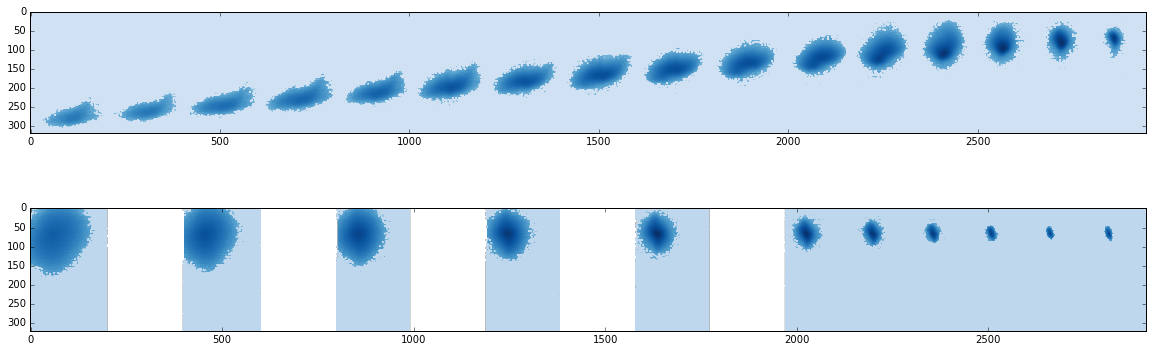

In [120]:
# _0_08, _7_4

#bb_0_08 = dict()
#bb_0_08 = copy.deepcopy({x:avr_dataD[x][1].image for x in sorted(avr_dataD)})

##for x in sorted(avr_dataD):
##    bb[x] = avr_dataD[x][1].image

setp = bb_0_08.keys()
setp = [363.0,363.1,363.2,363.3,363.4,363.5,363.6,363.7,363.8,363.9,364.0,364.1,364.2,364.3,364.4,364.5]
#setp = [-6.0,-5.0,-4.0,-3.0,-2.0,-1.0,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,10.0]
#setp = [-7.0,-6.0,-5.0,-4.0,-3.0,-2.0,-1.0,0.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,10.0]

figsize(20,10)

subplot(3,1,1)
b = pd.concat([pd.DataFrame(bb_0_08[x][0:320,0:200]) for x in sorted(setp)],axis=1)
#b = pd.concat([pd.DataFrame(bb_0_08[x][0:320,0:200]) for x in sorted(bb_0_08)],axis=1)
aaa = pd.DataFrame(gaussian_filter(log(b),0.5))
imshow(aaa.fillna(-9),cmap=get_cmap('Blues'))#vmin=0.01,
#imshow(b,cmap=get_cmap('Blues'))

subplot(3,1,2)
# дополнение пустыми картинками для непомеренных отстроек
for x in [363.1,363.3,363.5,363.7,363.9]:
    bb_7_4[x] = zeros(bb_7_4[363.0].shape)
b = pd.concat([pd.DataFrame(bb_7_4[x][0:320,0:200]) for x in sorted(setp)],axis=1)
#b = pd.concat([pd.DataFrame(bb_7_4[x][0:320,0:200]) for x in sorted(bb_7_4)],axis=1)
aaa = pd.DataFrame(gaussian_filter(log(b),0.5))
imshow(aaa.fillna(-9),cmap=get_cmap('Blues'))#vmin=0.01,
#imshow(b,cmap=get_cmap('Blues'))


#subplot(3,1,3)
#bb_364_6[-7] = zeros(bb_364_6[-6].shape)
#b = pd.concat([pd.DataFrame(bb_364_6[x][0:320,0:200]) for x in sorted(setp)],axis=1)
#b = pd.concat([pd.DataFrame(bb_364_6[x][0:320,0:200]) for x in sorted(bb_364_6)],axis=1)
#aaa = pd.DataFrame(gaussian_filter(log(b),0.5))
#imshow(aaa.fillna(-9),cmap=get_cmap('Blues'))#vmin=0.01,
#imshow(b,cmap=get_cmap('Blues'))

#imshow(bb[364.4],vmax=0.37)
#colorbar()

In [109]:
comp = pd.concat([b,b1],axis=0)
figsize(20,10)
imshow(b1,cmap=get_cmap('Blues'))

InvalidIndexError: Reindexing only valid with uniquely valued Index objects

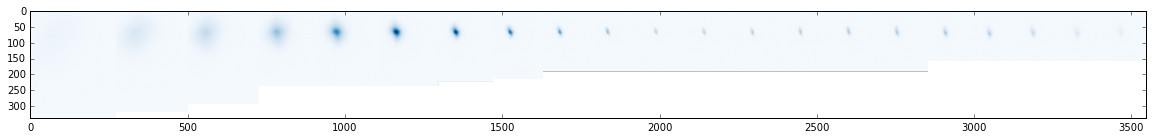

In [56]:
tmp_binning=2
tmp_pixel_size = 22.3/4
if folder == '02 LT a=0dBm/':
    for x in [364.5001,364.5002,363.4,363.4001]:
        tmp_arr = zeros(avr_dataD[x][1].image.shape)
        #m=50
        a,aa = math.modf(((77.14926138+94.49003226)/2+41.36346944)/(tmp_binning*tmp_pixel_size))
        tmp_arr[aa:,:] = avr_dataD[x][1].image[:-aa,:]
        avr_dataD[x][1].image = tmp_arr
b = pd.concat([pd.DataFrame(avr_dataD[x][1].image) for x in sorted(avr_dataD)],axis=1)
figsize(20,10)
imshow(b,cmap=get_cmap('Blues'))

In [57]:
#help(subplots)

### Construct data based on measurement type and plot

In [58]:
#def linear(x,k,b):
 #   return k*x + b
def linear(x,k,b):
    return k*x + b

In [34]:
# shot_typeN - for now only 1, if there will be calibration - 1 or more
shot_typeN = 1

# description to add to all_data.txt file
description = dict()
description['meas_type'] = meas_type
description['x_label'] = x_lbl
description['y_label'] = y_lbl

# meas_type = 'T' # here one can specify type to get desired plots
meas_type = 'LT'
fit_func = None
fits_list = []
fig1, ax1 = subplots()
if meas_type == 'T':
    # construct data with cloud expansion on both coordinates
    # first set of data  - Temperature X
    d1 = impr.get_avr_data(navrD, shot_typeN, 'fit1D_x',2)
    d1['fmt']='ro'
    d1['label']='fit1D_x'
    #impr.drop_by_number(d1,5)
    #impr.drop_by_x(d1,130,160)

    # second set of data  - Temperature Y
    d2 = impr.get_avr_data(navrD, shot_typeN,  'fit1D_y',2)
    d2['fmt']='bo'
    d2['label'] = 'fit1D_y'
    #impr.drop_by_number(d2,5)
    
    # fit cloud expansion
    fit_func = usfuncs.cloud_expansion0
    popt_T, pcov_T = curve_fit(fit_func, d1['x'], d1['y'], p0=(d1['y'][0],20))
    perr_T = np.sqrt(np.diag(pcov_T))
    fits_list.append([fit_func.__name__,list(popt_T), list(perr_T)])
    popt_T2, pcov_T2 = curve_fit(fit_func, d2['x'], d2['y'], p0=(d2['y'][0], 20))
    perr_T2 = np.sqrt(np.diag(pcov_T2))
    fits_list.append([fit_func.__name__,list(popt_T2), list(perr_T2)])
#     print('Fit parameters X, Y:\n' + usfuncs.construct_fit_description(fit_func, list(zip(popt_T,popt_T2))))
    
    # plot data and fits 
    ax1.errorbar(**d2)
    ax1.errorbar(**d1)
    ax1.plot(linspace(min(d1['x']),max(d1['x']),100), fit_func(linspace(min(d1['x']),max(d1['x']),100),*popt_T),
             'r', label='Tx=%.2f$\pm$%.1f'%(popt_T[0],perr_T[0]))
    ax1.plot(linspace(min(d2['x']),max(d2['x']),100), fit_func(linspace(min(d2['x']),max(d2['x']),100),*popt_T2),
             'b', label='Ty=%.2f$\pm$%.1f'%(popt_T2[0],perr_T2[0]))
    ax1.set_xlim(min(d1['x'])-1, max(d1['x'])+1)
    # add information about fits to description
    description['fit1D_x'] =  popt_T
    description['fit1D_y'] =  popt_T2
    description['fit-function'] = fit_func.__name__
else:
    # construct data, param - what value to use
    smalldelta=0;
    if folder == '02 LT a=0dBm/':
        smalldelta=(77.14926138+94.49003226)/2+41.36346944 # only for folder 02 because of the replacing of the camera
    
    param = ['fit1D_y',1]
    d1 = impr.get_avr_data(navrD, shot_typeN, *param)
    d1['fmt']='ro'
    d1['label']=param
    d1['x'] = 2*364.7-2*d1['x']
    if folder == '02 LT a=0dBm/':
        d1['y'][0]=d1['y'][0]+smalldelta
        d1['y'][1]=d1['y'][1]+smalldelta
        d1['y'][10]=d1['y'][10]+smalldelta
        d1['y'][11]=d1['y'][11]+smalldelta
    #d1['y'] = 827-d1['y']
    d1['y'] = min(d1['y'])-d1['y']
    #d1['x'] = (2*364.7-2*d1['x'])/0.35

    #impr.drop_by_number(d1,*range(20,len(d1['x'])))
    #impr.drop_by_x(d1,130,160)
    
    param = ['fit1D_y',1]
    d2 = impr.get_avr_data(navrD, shot_typeN, *param)
    d2['fmt']='bo'
    d2['label']=param
    d2['x'] = 2*364.7-2*d2['x']
    if folder == '02 LT a=0dBm/':
        d2['y'][0]=d2['y'][0]+smalldelta
        d2['y'][1]=d2['y'][1]+smalldelta
        d2['y'][10]=d2['y'][10]+smalldelta
        d2['y'][11]=d2['y'][11]+smalldelta
    #d2['y'] = 827-d2['y']
    d2['y'] = min(d2['y'])-d2['y']
    #d2['x'] = (2*364.7-2*d2['x'])/0.35

    if folder == '01 LT a=1dBm/':
        impr.drop_by_number(d2,18,17,16,15,14,13,12,11,10,9) # for folder 01
    if folder == '02 LT a=0dBm/':
        impr.drop_by_number(d2,12,11,10,9,8,7) # for folder 02
    if folder == '03 LT a=-1dBm/':
        impr.drop_by_number(d2,7,6) # for folder 03
    if folder == '04 LT a=2dBm/':
        impr.drop_by_number(d2,9,8,7,6,5) # for folder 04
    if folder == '05 LT a=-2dBm/':
        impr.drop_by_number(d2,6,5) # for folder 03
    
    #ax1.errorbar(**d1)
    #ax1.errorbar(**d2)
    
    # fit_func - which function to use to fit data  here one can put conditions on meas_type to choose fit
    popt_T = None
    # fit_func = usfuncs.exp_decay_no_bg
    # popt_T, pcov_T = curve_fit(fit_func, d1['x'], d1['y'], p0=(d1['y'][0], 100))
    fit_func = linear
    popt_T, pcov_T = curve_fit(fit_func, d2['x'], d2['y'])
    
#     #popt_T, pcov_T = curve_fit(fit_func, d1['x'], d1['y'], p0=(-d1['y'][0], d1['x'][argmin(d1['y'])],0.1,d1['y'][0]))
#     print('Fit parameters:\n' + usfuncs.construct_fit_description(fit_func, popt_T))
    perr_T = np.sqrt(np.diag(pcov_T))
    
    # plot data and fits
    ax1.errorbar(**d1)
    ax1.errorbar(**d2)
    if fit_func != None:
        ax1.plot(linspace(min(d2['x']),max(d2['x']),100), fit_func(linspace(min(d2['x']),max(d2['x']),100),*popt_T),'k', label='fit X')
        fit_label = fit_func.__name__ + ' fit:\n' + usfuncs.construct_fit_description(fit_func, list(zip(popt_T,perr_T)),sep='$\pm$')
        ax1.text(0.01,0.01,fit_label,transform=ax1.transAxes)
        description['fit'] =  popt_T
        description['fit-function'] = fit_func.__name__
        fits_list.append([fit_func.__name__,list(popt_T), list(perr_T)])
    
x_lbl='Detuning, MHz'
y_lbl='Vertical position, um'
ax1.set_xlabel(x_lbl)
ax1.set_ylabel(y_lbl)
#ax1.set_title(folder.rstrip(r'\/ '))
#ax1.set_ylim(bottom=0)
#ax1.legend(loc=4)

print('Number of atoms', avr_table.T[0].fit1D_x.N, '+-', avr_table.T[0].fit1D_x_std.N)
print(d1)
#print(d1['y'])

NameError: name 'meas_type' is not defined

In [591]:
d1['y'][d1['x'] == 1.400][0]

IndexError: index 0 is out of bounds for axis 0 with size 0

In [592]:
d1['x'][0]

1.3999999999999773

In [593]:
d1['x'] == 1

array([False, False,  True, False, False, False, False], dtype=bool)

In [594]:
#help(errorbar)
navrD.keys()

dict_keys([364.2, 364.45, 364.4501, 364.3, 364.1, 364.0, 364.4])

(0, 20.0)

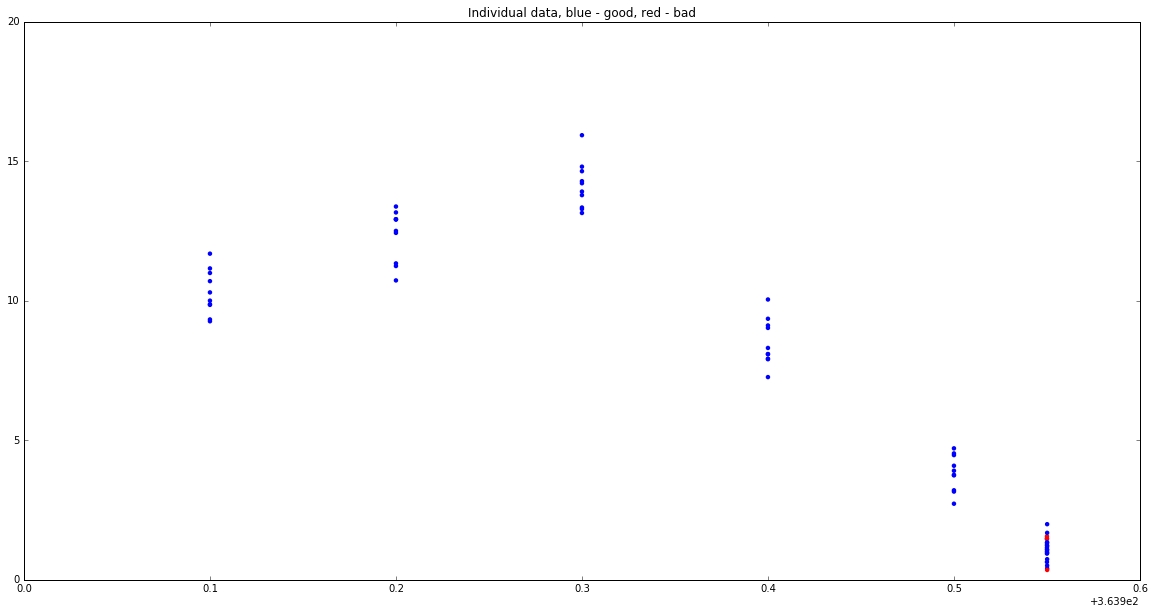

In [595]:
# for each picture
shot_typeN = 1
xs, ys, cs = impr.constract_data_scatter(dataD, shot_typeN, 'fit1D_y',0)
# plt.figure(figsize=(13,4))
scatter(xs,ys,c=cs,linewidths=0)
title("Individual data, blue - good, red - bad")
ylim(bottom=0)

In [596]:
# show 2D image
# imshow(avr_dataD[0.2][1].image)

In [597]:
if folder != '':
    fig1.savefig(os.path.join('Figures',folder.rstrip(r'\/ ')+'.png'))
    # save pandas table to csv file
    avr_table.to_csv(os.path.join(folder,'avr_table.csv'))
    try:
        with open('all_data.txt', 'rb') as handle:
            res_dict = pickle.loads(handle.read())
    except FileNotFoundError:
        res_dict = {}
    except EOFError:
        res_dict = {}
    res_dict[folder.rstrip(r'\/ ')]={'description':description,'data':navrD}
    with open('all_data.txt', 'wb') as handle:
        pickle.dump(res_dict, handle)
    with open('all_data.json', 'w') as outfile:
        json.dump(res_dict, outfile, cls=impr.JsonCustomEncoder, indent=4)    
    print('Figure and data saved!!!')
    
# to later read json file run following two lines
#with open('all_data.json', 'r') as infile:
#        ddata = json.load(infile)

#save to mongo db
# get pickle string of avr_table 
ss = 'temp'
avr_table.to_pickle(ss)
with open(ss,'rb') as fl:
    line = fl.read()
os.remove(ss)
# prepear dictionary to load to mongoDB
data_to_db = {
             'date_meas':datetime.datetime.strptime(current_directory[:10],'%Y_%m_%d'),
             'date_mod':datetime.datetime.now(),
             'folder':folder,
             'meas_type':meas_type,
             'labels':[x_lbl, y_lbl],
              'conf_params':conf_params,
              'fits': fits_list,
              'avr_table_pickle':line
             }
# try to find entery with the same 'date_meas' and 'folder' and either update or create entery
res = meas_database.find_one({'date_meas':datetime.datetime.strptime(current_directory[:10],'%Y_%m_%d'),
                 'folder':folder})
if res:
    print('Entery for folder "%s" updated' % folder)
    meas_database.update_one({'_id':res['_id']},{'$set':data_to_db})
else:
    print('Entery for folder "%s" created' % folder)
    meas_database.insert_one(data_to_db)

Figure and data saved!!!


ValueError: time data 'Vertical p' does not match format '%Y_%m_%d'

#### Force and Potential for MOT

In [232]:
γ=0.350 # MHz
#γ=0.0075 # MHz
Γ=2*pi*γ # MHz

λ=531*10**(-9) # nm
#λ=689*10**(-9) # nm
k=2*pi/λ

μB=927.4*10**(-26) # Дж/Тл
hbar=10**(-34) # Дж*с
μ=1*μB/hbar
μG=1*μB/hbar
μG=0
μE=1*μB/hbar
dB=19*10**(-2)/4*1.5 # Тл/м

m=169*1.66*10**(-27) # kg
#m=88*1.66*10**(-27) # kg
g=10 # m/s

kB=1.38*10**(-23) # Дж/К

def Force(δ,s,v,z,mF=0):
    return (0.5*hbar*k*Γ*10**6)*(s/(1+s+4*(2*pi*δ-k*v*10**(-6)-((mF+1)*μE-mF*μG)*dB*10**(-9)*z)**2/Γ**2)
                                 -s/(1+s+4*(2*pi*δ+k*v*10**(-6)-((mF-1)*μE-mF*μG)*dB*10**(-9)*z)**2/Γ**2)) - m*g

def Potential(δ,s,v,z,mF=0): # проинтегрировано в Математике
    return -10**(-3)*(0.5*hbar*k*Γ*10**6)*(s*pi*γ*10**9)*((arctan((-2*pi*λ*δ+2*pi*v*10**(-6)+λ*((mF+1)*μE-mF*μG)*dB*10**(-9)*z)/(γ*λ*pi*sqrt(1+s))))/(dB*((mF+1)*μE-mF*μG)*sqrt(1+s)) - 
                    (arctan((2*pi*λ*δ+2*pi*v*10**(-6)-λ*((mF-1)*μE-mF*μG)*dB*10**(-9)*z)/(γ*λ*pi*sqrt(1+s))))/(-dB*((mF-1)*μE-mF*μG)*sqrt(1+s))) + 10**(-3)*m*g*z
    #return -10**(-3)*(0.5*hbar*k*Γ*10**6)*(s*pi*γ*10**9)*((arctan((-2*pi*λ*δ+2*pi*v*10**(-6)+λ*μ*dB*10**(-9)*z)/(γ*λ*pi*sqrt(1+s))))/(dB*μ*sqrt(1+s)) - 
    #(arctan((2*pi*λ*δ+2*pi*v*10**(-6)+λ*μ*dB*10**(-9)*z)/(γ*λ*pi*sqrt(1+s))))/(dB*μ*sqrt(1+s))) + 10**(-3)*m*g*z
# коэффициент 10**(-3) из-за того, что z в миллиметрах

#### Стронций, для сравнения со статьей, сила от координаты или скорости при разных отстройках

950.8848063712676 мкм/МГц


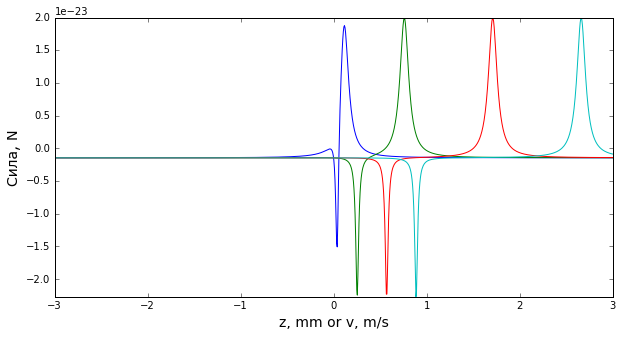

In [244]:
# стронций, для сравнения со статьей, сила

γ=0.0075 # MHz
Γ=2*pi*γ # MHz
λ=689*10**(-9) # nm
k=2*pi/λ
m=88*1.66*10**(-27) # kg
dB=19*10**(-2)/4*1.5 # Тл/м

z = linspace(-3,3,1000) # mm for z or m/s for v
v = 0
s = 250

figsize(10,5)
for δ in [-0.12,-0.8,-1.8,-2.8]: # MHz
    y = Force(δ,s,v,z,mF=-2) # dependence on z
    #y = Force(δ,s,z,v,mF=0) # dependence on v
    plot(z,y)

print(2*pi*10**(12)/(μ*dB),'мкм/МГц')
axis('tight')
xlabel('z, mm or v, m/s', fontsize=14)
ylabel('Сила, N', fontsize=14, family="verdana")

#### Стронций, для сравнения со статьей, потенциал от координаты при разных отстройках

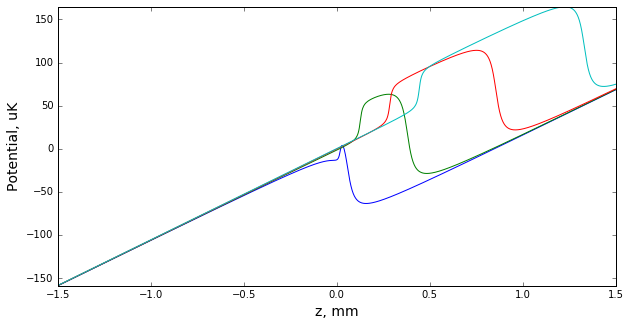

In [246]:
# стронций, для сравнения со статьей, потенциал

γ=0.0075 # MHz
Γ=2*pi*γ # MHz
λ=689*10**(-9) # nm
k=2*pi/λ
m=88*1.66*10**(-27) # kg
dB=2*19*10**(-2)/4*1.5 # Тл/м

z = linspace(-1.5,1.5,1000) # mm
v = 0
s = 250
#m=0

figsize(10,5)
for δ in [-0.12,-0.8,-1.8,-2.8]: # MHz
    y = 10**6*(Potential(δ,s,v,z,mF=-2) - Potential(-2.8,s,v,0,mF=-2))/kB
    plot(z,y)
    
axis('tight')
xlabel('z, mm', fontsize=14)
ylabel('Potential, uK', fontsize=14)

#### Стронций, для сравнения со статьей, сила от координаты или скорости при разных мощностях

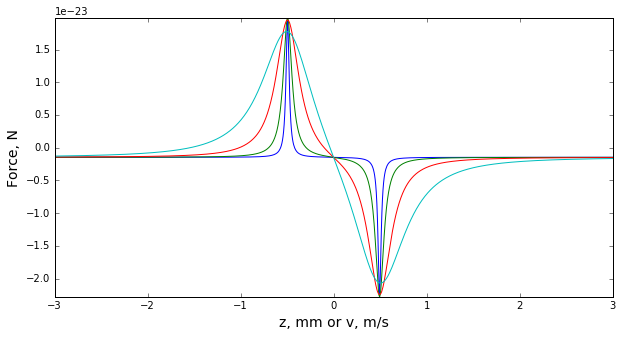

In [642]:
# стронций, для сравнения со статьей, сила

γ=0.0075 # MHz
Γ=2*pi*γ # MHz
λ=689*10**(-9) # nm
k=2*pi/λ
m=88*1.66*10**(-27) # kg
dB=19*10**(-2)/4*1.5 # Тл/м

z = linspace(-3,3,1000) # mm for z or m/s for v
v = 0
δ = -0.52

figsize(10,5)
for s in [33,248,1800,9120]:
    y = Force(δ,s,v,z) # dependence on z
    #y = Force(δ,s,z,v) # dependence on v
    plot(z,y)

#print(2*pi*10**(12)/(μ*dB),'мкм/МГц')
axis('tight')
xlabel('z, mm or v, m/s', fontsize=14)
ylabel('Force, N', fontsize=14)

#### Стронций, для сравнения со статьей, потенциал от координаты при разных мощностях

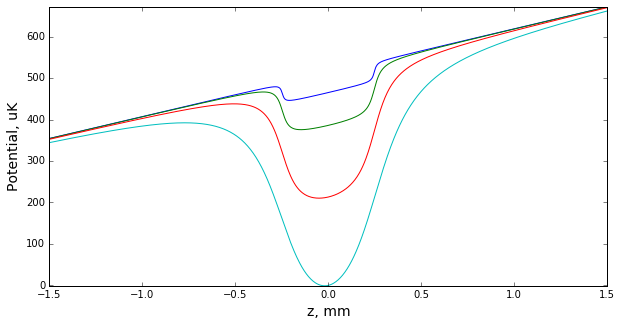

In [643]:
# стронций, для сравнения со статьей, потенциал

γ=0.0075 # MHz
Γ=2*pi*γ # MHz
λ=689*10**(-9) # nm
k=2*pi/λ
m=88*1.66*10**(-27) # kg
dB=2*19*10**(-2)/4*1.5 # Тл/м

z = linspace(-1.5,1.5,1000) # mm
v = 0
δ = -0.52

figsize(10,5)
for s in [33,248,1800,9120]:
    y = 10**6*(Potential(δ,s,v,z) - Potential(δ,9120,v,0))/kB
    plot(z,y)
    
axis('tight')
xlabel('z, mm', fontsize=14)
ylabel('Potential, uK', fontsize=14)

#### Тулий, сила от координаты или скорости при разных отстройках

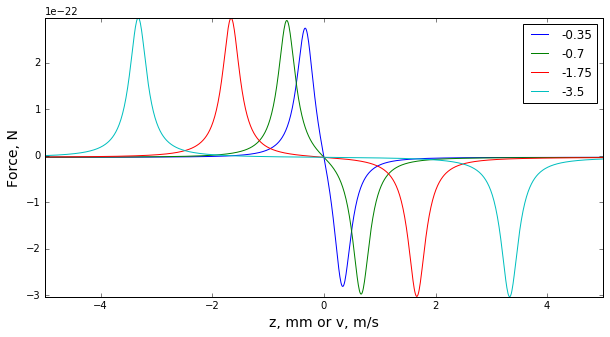

In [12]:
# тулий, сила

γ=0.35 # MHz
Γ=2*pi*γ # MHz
λ=531*10**(-9) # nm
k=2*pi/λ
m=169*1.66*10**(-27) # kg
dB=19*10**(-2)/4*1.5 # Тл/м

z = linspace(-5,5,1000) # mm for z or m/s for v
v = 0
s = 0.3

figsize(10,5)
δset=[-γ,-2*γ,-5*γ,-10*γ]
#print(-6*γ)
for δ in δset: # MHz
    y = Force(δ,s,v,z) # dependence on z
    #y = Force(δ,s,z,v) # dependence on v
    plot(z,y)

#print(2*pi*10**(12)/(μ*dB),'мкм/МГц')
axis('tight')
xlabel('z, mm or v, m/s', fontsize=14)
ylabel('Force, N', fontsize=14)
legend(δset)

#### Тулий, потенциал от координаты при разных отстройках

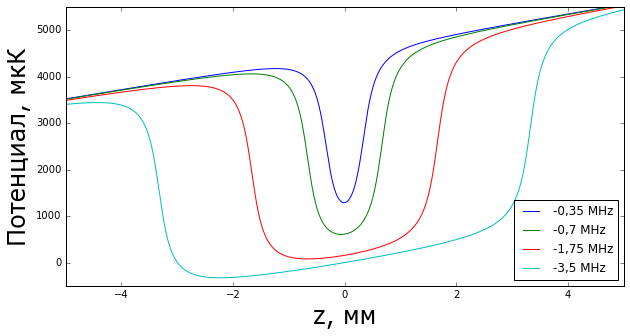

In [33]:
# Тулий, потенциал

γ=0.35 # MHz
Γ=2*pi*γ # MHz
λ=531*10**(-9) # nm
k=2*pi/λ
m=169*1.66*10**(-27) # kg
dB=19*10**(-2)/4*1.5 # Тл/м

z = linspace(-5,5,1000) # mm for z or m/s for v
v = 0
#s = 7.4
s = 0.1

figsize(10,5)
for δ in δset: # MHz
    y = 10**6*(Potential(δ,s,v,z) - Potential(-10*γ,s,v,0))/kB
    plot(z,y)
    
axis([-5,5,-500,5500])
#axis([-5,5,-500,120000])
xlabel('z, мм', fontsize=24, family='verdana')
ylabel('Потенциал, мкК', fontsize=24, family='verdana')
#legend(δset,loc=4)
legend(['-0,35 MHz','-0,7 MHz','-1,75 MHz','-3,5 MHz'],loc=4)

#### Тулий, сила от координаты при разных мощностях

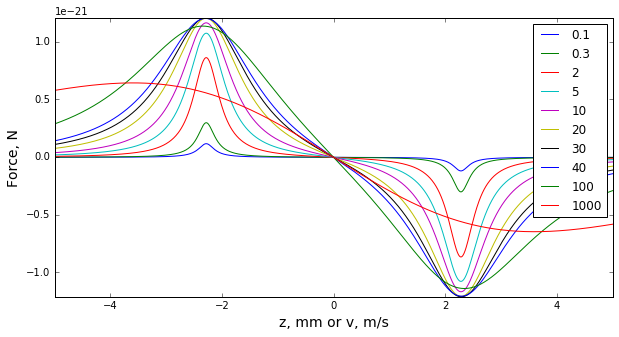

In [336]:
# тулий, сила

γ=0.35 # MHz
Γ=2*pi*γ # MHz
λ=531*10**(-9) # nm
k=2*pi/λ
m=169*1.66*10**(-27) # kg
dB=19*10**(-2)/4*1.5 # Тл/м

z = linspace(-5,5,1000) # mm for z or m/s for v
v = 0
δ = -2.4#-5*γ

figsize(10,5)
sset=[0.1,0.3,2,5,10,20,30,40,100,1000]
for s in sset:
    y = Force(δ,s,v,z) # dependence on z
    #y = Force(δ,s,z,v) # dependence on v
    plot(z,y)

#print(2*pi*10**(12)/(μ*dB),'мкм/МГц')
axis('tight')
xlabel('z, mm or v, m/s', fontsize=14)
ylabel('Force, N', fontsize=14)
legend(sset)

#### Тулий, потенциал от координаты при разных мощностях

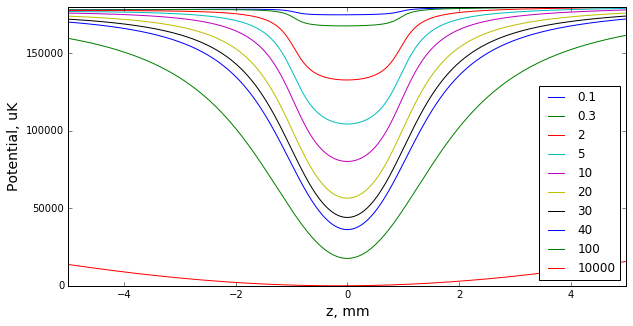

In [334]:
# Тулий, потенциал

γ=0.35 # MHz
Γ=2*pi*γ # MHz
λ=531*10**(-9) # nm
k=2*pi/λ
m=169*1.66*10**(-27) # kg
dB=19*10**(-2)/4*1.5 # Тл/м

z = linspace(-5,5,1000) # mm for z or m/s for v
v = 0
δ = -1.0#-15*γ

figsize(10,5)
sset=[0.1,0.3,2,5,10,20,30,40,100,10000]
for s in sset:
    y = 10**6*(Potential(δ,s,v,z) - Potential(δ,max(sset),v,0))/kB
    plot(z,y)
    
axis('tight')
xlabel('z, mm', fontsize=14)
ylabel('Potential, uK', fontsize=14)
legend(sset,loc=4)

#### Тулий, минимум потенциала от координаты и мощности

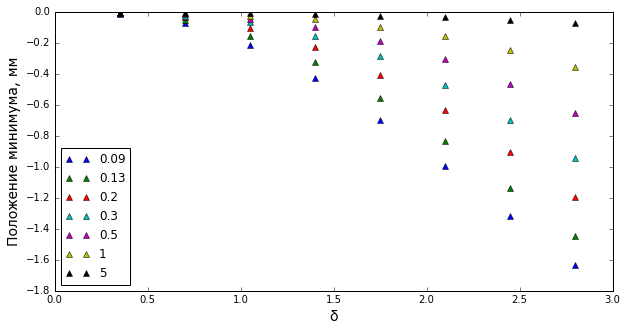

In [284]:
# Тулий, потенциал

γ=0.35 # MHz
Γ=2*pi*γ # MHz
λ=531*10**(-9) # nm
k=2*pi/λ
m=169*1.66*10**(-27) # kg
dB=19*10**(-2)/4*1.5 # Тл/м

z = linspace(-5,5,1000) # mm for z or m/s for v
v = 0
sset=[0.09,0.13,0.2,0.3,0.5,1,5]
#sset=[0.3]
δset=[-γ,-2*γ,-3*γ,-4*γ,-5*γ,-6*γ,-7*γ,-8*γ]
#δset=[-15*γ]

figsize(10,5)
for s in sset:
    y = []
    y1 = []
    for idx,δ in enumerate(δset):       
        tmp = 10**6*(Potential(δ,s,v,z))/kB
        #zmin = z[where(np.isclose(tmp,min(tmp)))[0][0]]
        #zmin = z[where(np.ismin(abs(tmp-min(tmp)))[0][0]]
        #y.append(zmin)
        zmin = z[argmin(tmp)]
        y1.append(zmin)
    #plot(abs(array(δset)),y,'o')
    plot(abs(array(δset)),y1,'^')
#errorbar(**d1)    
#axis([min(δset)-γ,0,-2.5,0])
# axis([0,max(abs(array(δset)))+γ,-2.,0.5])
xlabel('δ', fontsize=14, family='verdana')
ylabel('Положение минимума, мм', fontsize=14, family='verdana')
legend(sset,loc=3)

In [83]:
def modes(s,γ):
    return γ*sqrt(1+s)

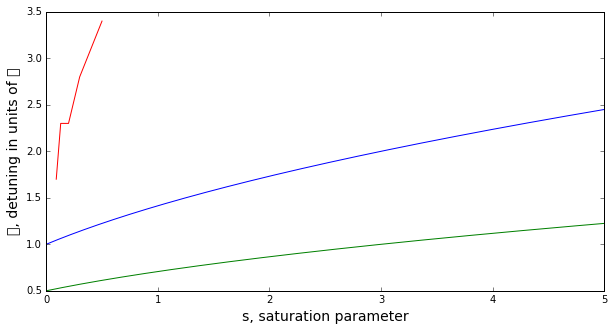

In [207]:
γ = 0.35 # MHz
Exp_δ = [1.7,2.3,2.3,2.8,3.4] # in units of γ
Exp_s = [0.09,0.13,0.2,0.3,0.5]
s = linspace(0,5,1000)
figsize(10,5)
δ = modes(s,γ)/γ
δmin = δ/2
plot(s,δ)
plot(s,δmin)
plot(Exp_s,Exp_δ)
xlabel('s, saturation parameter', fontsize=14)
ylabel('δ, detuning in units of γ', fontsize=14)

In [14]:
def Temperature1(δ,s): # U mode
    return (0.5*hbar*Γ*sqrt(1+beams*s)*1e6/kB)*(0.25*γ*sqrt(1+beams*s)/δ+δ/(γ*sqrt(1+beams*s)))*1e6
def Temperature2(δ,s): # V mode
    return (0.5*hbar*Γ*1e6*sqrt(s)/kB)*(0.5*R/sqrt(R-s/s-1/s))*1e6+0*δ
def Temperature2app(δ,s):# тулий
    return (0.5*hbar*Γ*1e6*sqrt(s)/kB)*(0.5*sqrt(R))*1e6
def τ1(s): # время установления равновесия U mode
    return 0.5*m*3*γ*(1+beams*s+4*(δ/γ)**2)**2/(4*hbar*k**2*δ*beams*s)*1000
def τ2(s): # время установления равновесия V mode
    return 0.5*m*R**2*s/(2*hbar*k**2*sqrt(R*s-s-1))*1000

11.855698048486765


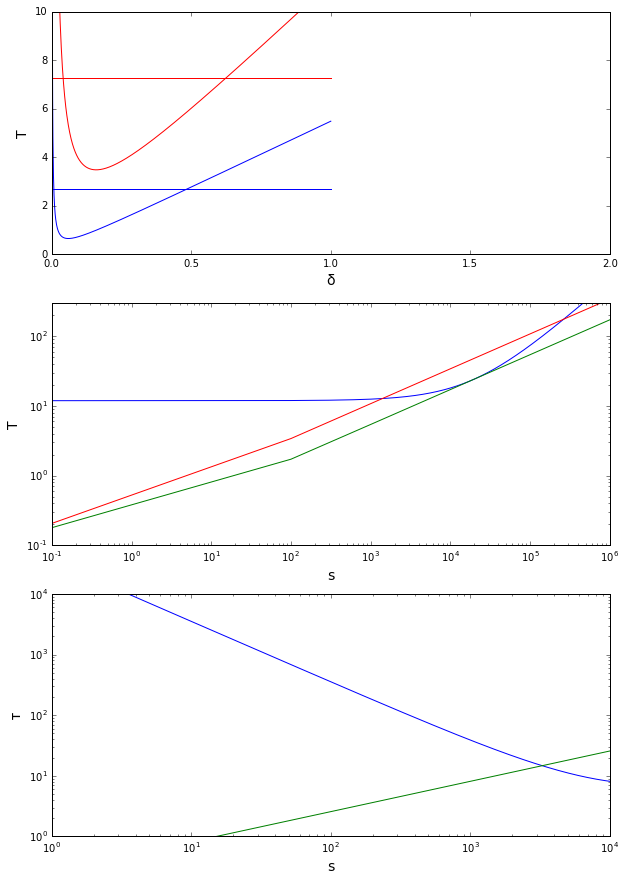

In [24]:
# стронций, для сравнения со статьей, температура от отстройки

γ=0.0075 # MHz
Γ=2*pi*γ # MHz
λ=689*10**(-9) # m
k=2*pi/λ
m=88*1.66*10**(-27) # kg

R=hbar*k*Γ*1e6/(2*m*g)

δ = linspace(0,1,1000) # MHz здесь без минуса, так как в формуле модуль на самом деле
#sset = [1,10,248,1800,10000]
sset = [248,1800]
ScFa = [0.24,0.48] # for U mode
#ScFa = [1,1,1]

#NuFa = 1/(0.5*R/sqrt(R-s/s-1/s)) # for V mode
NuFa = 1

colorset = ['b','r']

numofplots=4
figsize(10,20)

# галки вместе с константами
beams=1
subplot(numofplots,1,1)
for idx,s in enumerate(sset):
    NuFa = 1/(0.5*R/sqrt(R-s/s-1/s))
    y1 = ScFa[idx]*Temperature1(δ,s)
    y2 = NuFa*Temperature2(δ,s)
    plot(δ,y1,colorset[idx])
    plot(δ,y2,colorset[idx])
axis([0,2,0,10])
xlabel('δ', fontsize=14, family="verdana")
ylabel('T', fontsize=14, family="verdana")

# от мощности
subplot(numofplots,1,2)
δ = 0.52 # MHz
s = linspace(0.1,1e6,10000)
NuFa = 1/(0.5*R/sqrt(R-s/s-1/s))
y1 = Temperature1(δ,s)
y2 = Temperature2(δ,s)/sqrt(s)*sqrt(1+s)*NuFa
y3 = Temperature2(δ,s)
gca().set_xscale('log')
gca().set_yscale('log')
plot(s,y1)
plot(s,y2)
plot(s,y3)
axis([0.1,1e6,0.1,300])
xlabel('s', fontsize=14)
ylabel('T', fontsize=14, family="verdana")

# стронций, для сравнения со статьей, время установления равновесия
subplot(numofplots,1,3)
δ = 0.52 # MHz
s = linspace(1,1e4,1000)
y1 = τ1(s)
y2 = τ2(s)
gca().set_xscale('log')
gca().set_yscale('log')
plot(s,y1)
plot(s,y2)
axis([1,1e4,1,1e4])
xlabel('s', fontsize=14)
ylabel('τ', fontsize=14, family="verdana")
print(τ1(4520))
#print(R)

5.825166308232841
35.4912279713


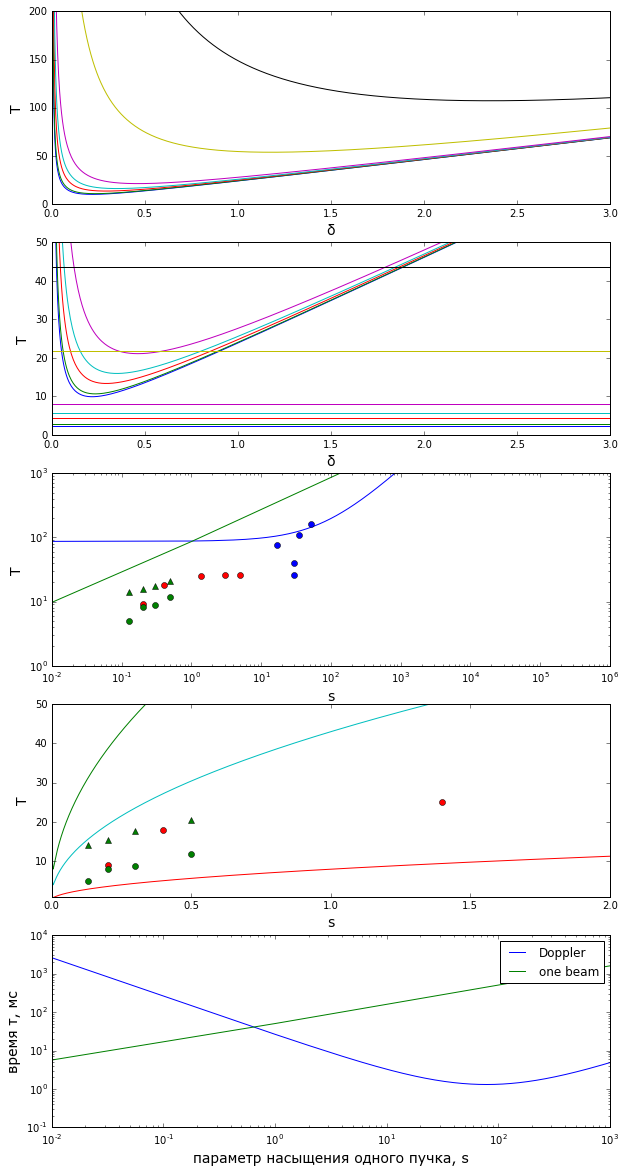

In [288]:
# тулий, температура от отстройки в режиме U

γ=0.35 # MHz
Γ=2*pi*γ # MHz
λ=531*10**(-9) # nm
k=2*pi/λ
m=169*1.66*10**(-27) # kg

R=hbar*k*Γ*1e6/(2*m*g)

δ = linspace(0,15*γ,1000) # MHz здесь без минуса, так как в формуле модуль на самом деле
#sset = [1,10,248,1800,10000]
sset = [0.09,0.13,0.3,0.5,1,7.4,30]
#ScFa = [0.24,0.48]
ScFa = [1,1,1,1,1,1,1,1]
NuFa = 1
colorset = ['b','g','r','c','m','y','k']
beams=6

numofplots=5
figsize(10,20)

# просто галки
subplot(numofplots,1,1)
for idx,s in enumerate(sset):
    y = ScFa[idx]*Temperature1(δ,s)
    plot(δ,y)
axis([0,3,0,200])
xlabel('δ', fontsize=14, family="verdana")
ylabel('T', fontsize=14, family="verdana")

# галки вместе с константами
subplot(numofplots,1,2)
for idx,s in enumerate(sset):
    NuFa = 1/(0.5*R/sqrt(R-s/s-1/s))
    y1 = ScFa[idx]*Temperature1(δ,s)
    y2 = NuFa*Temperature2(δ,s)
    plot(δ,y1,colorset[idx])
    plot(δ,y2,colorset[idx])
axis([0,3,0,50])
xlabel('δ', fontsize=14, family="verdana")
ylabel('T', fontsize=14, family="verdana")

Exper_s_old = [17,30,30,35,52]
Exper_T_old = [75,26,40,110,160]
Exper_s_2014_11 = [0.2,0.4,1.4,3,5]
Exper_T_2014_11 = [9,18,25,26,26.20]
Exper_s_2015_07 = [0.13,0.2,0.3,0.5]
Exper_Tx_2015_07 = [4.9,8.1,8.9,11.9]
# это горизонтальные Т
Exper_Ty_2015_07 = [14.2,15.5,17.6,20.6]
# это все для отстройки 2 МГц

# от мощности
#beams=1
subplot(numofplots,1,3)
δ = 3.8 # MHz
s = linspace(0.01,1e6,1000000)
NuFa = 1/(0.5*R/sqrt(R-s/s-1/s))
y1 = Temperature1(δ,s)
y2 = Temperature2(δ,s)
y3 = Temperature2(δ,s)*NuFa
y4 = Temperature2(δ,s)*0.5
#y5 = Temperature2app(δ,s)*NuFa
gca().set_xscale('log')
gca().set_yscale('log')
plot(s,y1)
plot(s,y2)
#plot(s,y3)
#plot(s,y4)
#plot(s,y5)
plot(Exper_s_old,Exper_T_old,'bo')
plot(Exper_s_2014_11,Exper_T_2014_11,'ro')
plot(Exper_s_2015_07,Exper_Tx_2015_07,'go')
plot(Exper_s_2015_07,Exper_Ty_2015_07,'g^')
axis([0.01,1e6,1,1000])
xlabel('s', fontsize=14)
ylabel('T', fontsize=14, family="verdana")

# от мощности
subplot(numofplots,1,4)
#δ = 2 # MHz
s = linspace(0,60,1000000)
y1 = Temperature1(δ,s)
y2 = Temperature2(δ,s)
y3 = Temperature2(δ,s)*NuFa
y4 = Temperature2(δ,s)*0.5
plot(s,y1)
plot(s,y2)
plot(s,y3)
plot(s,y4)
plot(Exper_s_old,Exper_T_old,'bo')
plot(Exper_s_2014_11,Exper_T_2014_11,'ro')
plot(Exper_s_2015_07,Exper_Tx_2015_07,'go')
plot(Exper_s_2015_07,Exper_Ty_2015_07,'g^')
axis([0,2,1,50])
xlabel('s', fontsize=14)
ylabel('T', fontsize=14, family="verdana")


#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
#время установления равновесия
subplot(numofplots,1,5)
δ = 3.8 # MHz --------------------------------------------------------------------здесь нужно выставлять отстройку в МГц
s = linspace(0.01,1e7,10000000)
y1 = τ1(s)
y2 = τ2(s)
#beams=1
#y3 = τ1(s)
gca().set_xscale('log')
gca().set_yscale('log')
plot(s,y1)
plot(s,y2)
#plot(s,y3)
axis([0.01,1e3,0.1,1e4])
xlabel('параметр насыщения одного пучка, s', fontsize=14, family="verdana")
ylabel('время τ, мс', fontsize=14, family="verdana")
legend(['Doppler','one beam'])

print(τ1(5)) # время установления в доплеровском режиме от параметра насыщения ОДНОГО пучка
print(τ2(0.5)) # время установления в однопучковом режиме от параметра насыщения ОДНОГО пучка
# чтобы из мощности одного пучка получить параметр насыщения, надо умножить на 1.38 и поделить на 0.32

In [5]:
def CrystalsTime(Δ,s,v,vinit):
    return 2*m/(hbar*k*s*Γ**3*10**18)*(4*k**2*v**3/3 - 4*Δ*10**6*k*v**2 + ((1+s)*Γ**2 + 4*Δ**2)*10**12*v - 4*k**2*vinit**3/3 + 4*Δ*10**6*k*vinit**2 - ((1+s)*Γ**2 + 4*Δ**2)*10**12*vinit)
def MeasTime(v):
    return 0*v+2

[ 0.05512  0.1378 ]


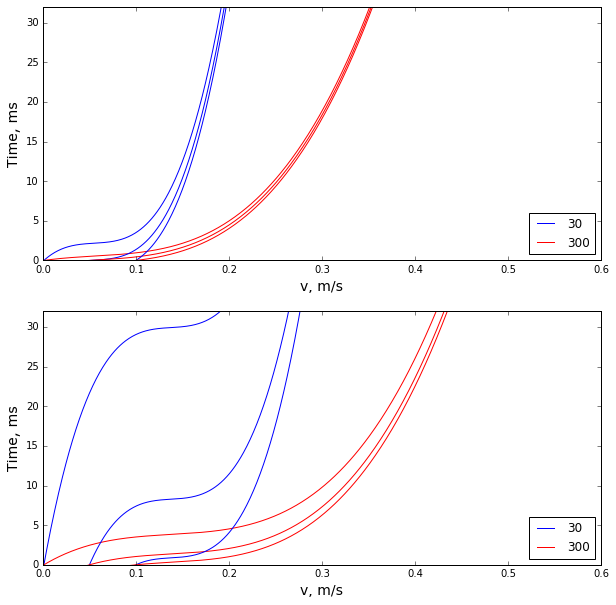

In [6]:
# стронций, для сравнения со статьей, кристаллы в импульсном пространстве, время от скорости

γ=0.0075 # MHz
Γ=2*pi*γ # MHz
λ=689*10**(-9) # m
k=2*pi/λ
m=88*1.66*10**(-27) # kg
dB=19*10**(-2)/4*1.5 # Тл/м

v = linspace(0,0.6,1000) # m/s
#δ = 0.2 # MHz
#Δ = 2*pi*δ

vinitset = [0.001,0.05,0.1] # m/s
sset = [30,300]
Δset = array([2*pi*0.08,2*pi*0.2]) # MHz
colorset = ['b','r'] # in according with sset!

figsize(10,10)
for idx, Δ in enumerate(Δset):
    subplot(len(Δset),1,idx+1)
    for vinit in vinitset: # m/s
        for iidx,s in enumerate(sset):
            y = CrystalsTime(Δ,s,v,vinit)*1000
            plot(v,y,colorset[iidx])
    axis([0,0.6,0,32])
    xlabel('v, m/s', fontsize=14)
    ylabel('Time, ms', fontsize=14, family="verdana")
    legend(sset,loc=4)
print(Δset*1e6/k)

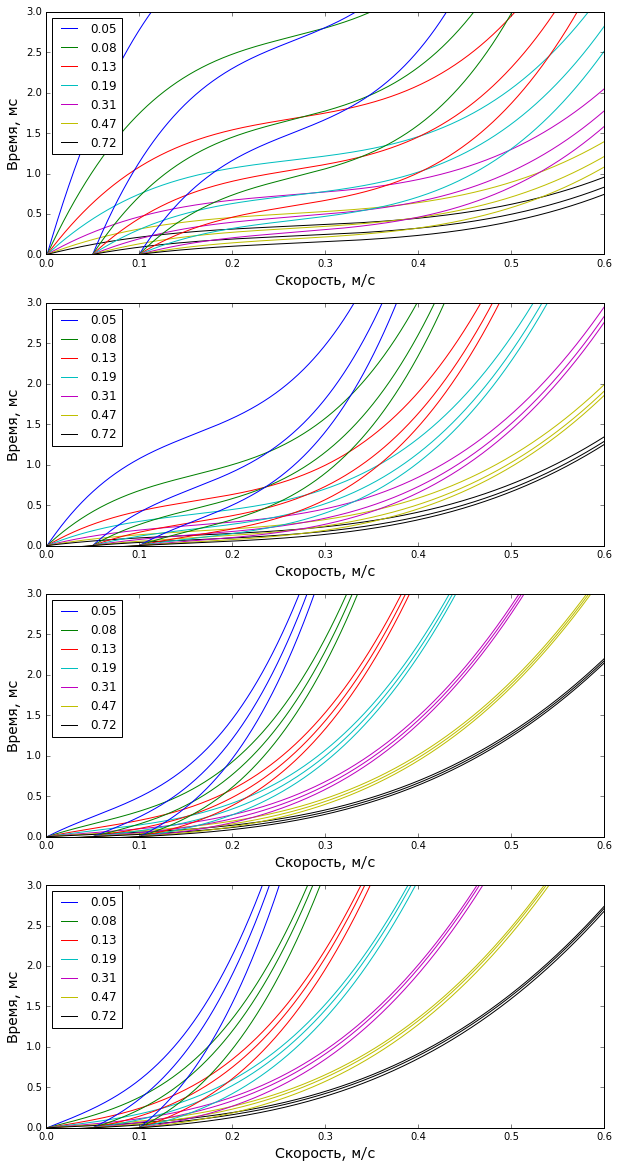

In [10]:
# тулий, кристаллы в импульсном пространстве, время от скорости

γ=0.35 # MHz
Γ=2*pi*γ # MHz
λ=531*10**(-9) # m
k=2*pi/λ
m=169*1.66*10**(-27) # kg
dB=19*10**(-2)/4*1.5 # Тл/м

v = linspace(0,0.6,1000) # m/s
math.modf(10)[1]
vinitset = array([0.001,0.05,0.1]) # m/s
sset = [math.modf(100*0.338/6)[1]/100, math.modf(100*0.52/6)[1]/100, 0.78/6, math.modf(100*1.196/6)[1]/100, 
        math.modf(100*1.872/6)[1]/100, math.modf(100*2.86/6)[1]/100, math.modf(100*4.342/6)[1]/100]
Δset = [2*pi*0.5,2*pi*0.3,2*pi*0.1,2*pi*0.01] # MHz
colorset = ['b','g','r','c','m','y','k'] # in according with sset!

figsize(10,20)
for idx, Δ in enumerate(Δset):
    subplot(len(Δset),1,idx+1)
    for vinit in vinitset: # m/s
        for iidx,s in enumerate(sset):
            y = CrystalsTime(Δ,s,v,vinit)*1000
            plot(v,y,colorset[iidx])
    axis([0,0.6,0,3])
    xlabel('Скорость, м/с', fontsize=14, family="verdana")
    ylabel('Время, мс', fontsize=14, family="verdana")
    legend(sset,loc=2)

#yy = MeasTime(v)
#plot(v,yy)

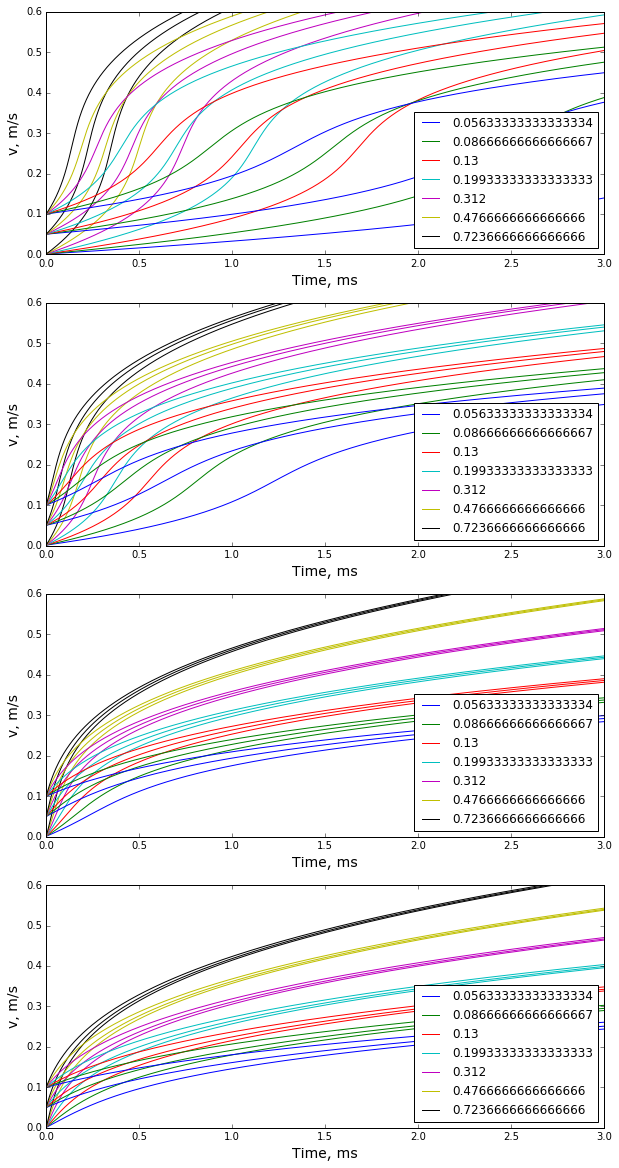

In [617]:
# тулий, кристаллы в импульсном пространстве, скорость от времени

γ=0.35 # MHz
Γ=2*pi*γ # MHz
λ=531*10**(-9) # m
k=2*pi/λ
m=169*1.66*10**(-27) # kg
dB=19*10**(-2)/4*1.5 # Тл/м

v = linspace(0,0.6,1000) # m/s
δ = 0.1 # MHz
Δ = 2*pi*δ

vinitset = [0.001,0.05,0.1] # m/s
#sset = [0.3,3]
sset = [0.338/6, 0.52/6, 0.78/6, 1.196/6, 1.872/6, 2.86/6, 4.342/6]
δset = [1,0.1,0.01]
Δset = [2*pi*0.5,2*pi*0.3,2*pi*0.1,2*pi*0.01]
colorset = ['b','g','r','c','m','y','k'] # in according with sset!

figsize(10,20)
for idx, Δ in enumerate(Δset):
    subplot(len(Δset),1,idx+1)
    for vinit in vinitset: # m/s
        for iidx,s in enumerate(sset):
            y = CrystalsTime(Δ,s,v,vinit)*1000
            plot(y,v,colorset[iidx])
    axis([0,3,0,0.6])
    ylabel('v, m/s', fontsize=14)
    xlabel('Time, ms', fontsize=14, family="verdana")
    legend(sset,loc=4)

#yy = MeasTime(v)
#plot(v,yy)

In [37]:
def parabola(x,k,b,x0):
    return k*(x-x0)**2 + b
def linear(x,k,b):
    return k*x + b

[ -1.90910714e-01  -7.43242690e+02   3.30363966e+01]
[  -93.41906967  1137.98181969]


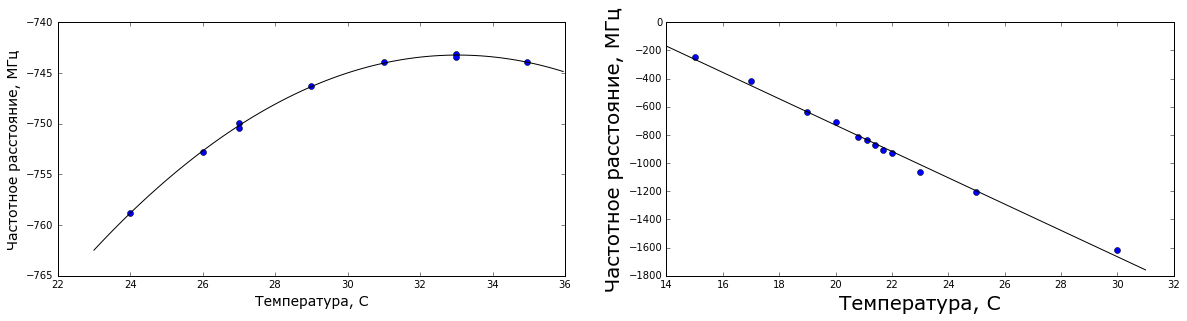

In [52]:
figsize(20,10)

# зависимость нового УЛЕ от Т
# 2*AOM_ULE+364.7 в красном смысле
ULEvsT = array([(29,746.3),(27,749.94),(26,752.84),(24,758.78),(27,750.42),(31,743.92),(33,743.18),(33,743.48),(34.95,743.88)])
subplot(2,2,1)
plot(ULEvsT[:,0],-ULEvsT[:,1],'o')
xlabel('Температура, С', fontsize=14, family="verdana")
ylabel('Частотное расстояние, МГц', fontsize=14, family="verdana")
#axis([])

fit_func = parabola
popt_T, pcov_T = curve_fit(fit_func, ULEvsT[:,0],-ULEvsT[:,1])
perr_T = np.sqrt(np.diag(pcov_T))
plot(linspace(min(ULEvsT[:,0])-1,max(ULEvsT[:,0])+1,100), fit_func(linspace(min(ULEvsT[:,0])-1,max(ULEvsT[:,0])+1,100),*popt_T),'k', label='fit X')
print(popt_T)


# зависимость старого УЛЕ от Т
# ULEvsT[:,1] = 800+2*AOM_1+2*AOM_2 в зеленом смысле
ULEvsT = array([(23,2130),(22,1850),(21.7,1820),(21.4,1744),(21.1,1670),(20.8,1625),(19.0,1280),(17.0,830),(20.0,1416),(25.0,2414),(30.0,3239),(15.0,501)])
subplot(2,2,2)
plot(ULEvsT[:,0],-ULEvsT[:,1]/2,'o')
xlabel('Температура, С', fontsize=20, family="verdana")
ylabel('Частотное расстояние, МГц', fontsize=20, family="verdana")
#axis([])

fit_func = linear
popt_T, pcov_T = curve_fit(fit_func, ULEvsT[:,0],-ULEvsT[:,1]/2)
perr_T = np.sqrt(np.diag(pcov_T))
plot(linspace(min(ULEvsT[:,0])-1,max(ULEvsT[:,0])+1,100), fit_func(linspace(min(ULEvsT[:,0])-1,max(ULEvsT[:,0])+1,100),*popt_T),'k', label='fit X')
print(popt_T)

[  7.54428589e-03  -7.44989416e+02]
[ -1.24778682e-04  -8.10968452e+02]
[  1.31899637e-03  -8.11192351e+02]


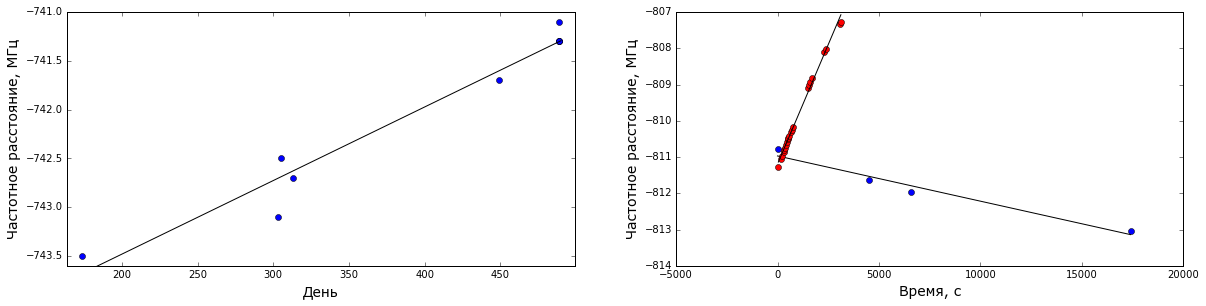

In [54]:
figsize(20,10)

# дрейф УЛЕ 1,06 начиная с 2015.06.24, когда выставили нулевуб точку 33 С
# ULEdrift[:,1] = АОМ бочки
ULEdrift = array( [(5*30+24, 189.4), (10*30+3, 189.2), (10*30+5, 188.9), (10*30+13, 189.0), (365+2*30+24, 188.5), 
                   (365+4*30+4, 188.3), (365+4*30+4, 188.3), (365+4*30+4, 188.3), (365+4*30+4, 188.3), (365+4*30+4, 188.2)] )
subplot(2,2,1)
plot(ULEdrift[:,0],-(2*ULEdrift[:,1]+364.7),'o')
xlabel('День', fontsize=14, family="verdana")
ylabel('Частотное расстояние, МГц', fontsize=14, family="verdana")
axis([min(ULEdrift[:,0])-10,max(ULEdrift[:,0])+10,-(2*max(ULEdrift[:,1])+364.7)-0.1,-(2*min(ULEdrift[:,1])+364.7)+0.1])

fit_func = linear
popt_T, pcov_T = curve_fit(fit_func, ULEdrift[:,0],-(2*ULEdrift[:,1]+364.7))
perr_T = np.sqrt(np.diag(pcov_T))
plot(linspace(min(ULEdrift[:,0])-1,max(ULEdrift[:,0])+1,100), fit_func(linspace(min(ULEdrift[:,0])-1,max(ULEdrift[:,0])+1,100),*popt_T),'k', label='fit X')
print(popt_T)


# дрейф старого УЛЕ, 2014.01.21 и 2014.01.22
# ULEdrift1[:,1] = АОМ_1
ULEdrift1 = array( [(0,207.79),(4500,208.63),(6600,208.96),(17400,210.05)])
subplot(2,2,2)
plot(ULEdrift1[:,0],-(ULEdrift1[:,1]+203+400),'bo')
xlabel('Время, с', fontsize=14, family="verdana")
ylabel('Частотное расстояние, МГц', fontsize=14, family="verdana")

fit_func = linear
popt_T, pcov_T = curve_fit(fit_func, ULEdrift1[:,0],-(ULEdrift1[:,1]+203+400))
perr_T = np.sqrt(np.diag(pcov_T))
plot(linspace(min(ULEdrift1[:,0])-1,max(ULEdrift1[:,0])+1,100), fit_func(linspace(min(ULEdrift1[:,0])-1,max(ULEdrift1[:,0])+1,100),*popt_T),'k', label='fit X')
print(popt_T)

ULEdrift2 = array([(44,2.26),(170,2.04),(224,1.98),(298,1.86),(340,1.8),(386,1.74),(424,1.66),(463,1.58),(500,1.5),(533,1.46),(572,1.42),
                   (644,1.3),(691,1.24),(760,1.16),(1490,0.08),(1555,0.02),(1615,-0.08),(1695,-0.18),(2300,-0.9),(2376,-0.98),(3066,-1.68),(3123,-1.74)])
plot(ULEdrift2[:,0],-(ULEdrift2[:,1]+206+203+400),'ro')
xlabel('Время, с', fontsize=14, family="verdana")
ylabel('Частотное расстояние, МГц', fontsize=14, family="verdana")

fit_func = linear
popt_T, pcov_T = curve_fit(fit_func, ULEdrift2[:,0],-(ULEdrift2[:,1]+206+203+400))
perr_T = np.sqrt(np.diag(pcov_T))
plot(linspace(min(ULEdrift2[:,0])-1,max(ULEdrift2[:,0])+1,100), fit_func(linspace(min(ULEdrift2[:,0])-1,max(ULEdrift2[:,0])+1,100),*popt_T),'k', label='fit X')
print(popt_T)

In [16]:
def w(w0,z0,z):
    λ = 1.06
    return sqrt(w0**2+(λ*(z+z0)*1e4/(pi*w0))**2)

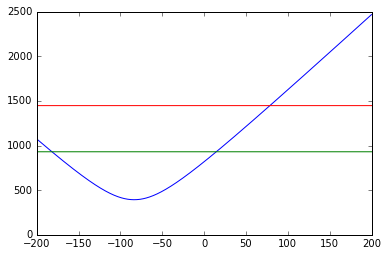

In [17]:
z = linspace(-200,200,10000)
w0 = 393
z0 = 83.6
plot(z,w(w0,z0,z))
plot(z,930+0*z)
plot(z,1447+0*z)